## 机器学习策略1.0—基于逻辑回归的股市涨跌趋势预测(及SVM策略)

In [1]:
%matplotlib inline
import seaborn
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore') #忽略可能会出现的警告信息，警告并不是错误，可以忽略；

### 1. 数据获取

In [2]:
import pandas as pd
import numpy as np
import tushare as ts

In [3]:
hs300 = ts.get_k_data('hs300', start = '2016-01-01', end = '2019-08-18')   #训练集数据

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [4]:
hs300.set_index('date', inplace = True)

In [5]:
hs300['returns'] = hs300['close'].pct_change()

In [6]:
hs300.dropna(inplace=True)            #有NaN值的话会影响机器学习算法, 会报错的，对NaN的处理： dropna, mean（）等；

In [7]:
hs300.head()

,open,close,high,low,volume,code,returns
date,,,,,,,
2016-01-05,3382.18,3478.78,3518.22,3377.28,162116984.0,hs300,0.002412
2016-01-06,3482.41,3539.81,3543.74,3468.47,145966144.0,hs300,0.017544
2016-01-07,3481.15,3294.38,3481.15,3284.74,44102641.0,hs300,-0.069334
2016-01-08,3371.87,3361.56,3418.85,3237.93,185959451.0,hs300,0.020392
2016-01-11,3303.12,3192.45,3342.48,3192.45,174638387.0,hs300,-0.050307


#### 2. 数据处理——特征工程处理

In [8]:
#特征工程不仅可以选择close(1)-(7)， 也可以选择SMA， SMA（5）， CCI等技术指标（TBD version 1.1, 1.2 ...）

#特征的生成；
for i in range(1, 8, 1):
    hs300['close - ' + str(i) + 'd'] = hs300['close'].shift(i)

In [9]:
hs300.head(8)

,open,close,high,low,volume,code,returns,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d
date,,,,,,,,,,,,,,
2016-01-05,3382.18,3478.78,3518.22,3377.28,162116984.0,hs300,0.002412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,3482.41,3539.81,3543.74,3468.47,145966144.0,hs300,0.017544,3478.78,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,3481.15,3294.38,3481.15,3284.74,44102641.0,hs300,-0.069334,3539.81,3478.78,NaN,NaN,NaN,NaN,NaN
2016-01-08,3371.87,3361.56,3418.85,3237.93,185959451.0,hs300,0.020392,3294.38,3539.81,3478.78,NaN,NaN,NaN,NaN
2016-01-11,3303.12,3192.45,3342.48,3192.45,174638387.0,hs300,-0.050307,3361.56,3294.38,3539.81,3478.78,NaN,NaN,NaN
2016-01-12,3214.82,3215.71,3242.25,3174.55,128225796.0,hs300,0.007286,3192.45,3361.56,3294.38,3539.81,3478.78,NaN,NaN
2016-01-13,3240.48,3155.88,3257.30,3155.88,120666494.0,hs300,-0.018606,3215.71,3192.45,3361.56,3294.38,3539.81,3478.78,NaN
2016-01-14,3076.64,3221.57,3226.66,3072.04,134537671.0,hs300,0.020815,3155.88,3215.71,3192.45,3361.56,3294.38,3539.81,3478.78


In [10]:
hs_7d = hs300[[x for x in hs300.columns if 'close' in x]].iloc[7:]   #从第八行开始没有NaN地方开始取值作为features

In [11]:
hs_7d.head(10)

,close,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d
date,,,,,,,,
2016-01-14,3221.57,3155.88,3215.71,3192.45,3361.56,3294.38,3539.81,3478.78
2016-01-15,3118.73,3221.57,3155.88,3215.71,3192.45,3361.56,3294.38,3539.81
2016-01-18,3130.73,3118.73,3221.57,3155.88,3215.71,3192.45,3361.56,3294.38
2016-01-19,3223.12,3130.73,3118.73,3221.57,3155.88,3215.71,3192.45,3361.56
2016-01-20,3174.38,3223.12,3130.73,3118.73,3221.57,3155.88,3215.71,3192.45
2016-01-21,3081.35,3174.38,3223.12,3130.73,3118.73,3221.57,3155.88,3215.71
2016-01-22,3113.46,3081.35,3174.38,3223.12,3130.73,3118.73,3221.57,3155.88
2016-01-25,3128.89,3113.46,3081.35,3174.38,3223.12,3130.73,3118.73,3221.57
2016-01-26,2940.51,3128.89,3113.46,3081.35,3174.38,3223.12,3130.73,3118.73


In [12]:
import sklearn
from sklearn import linear_model

In [13]:
X_train = hs_7d
X_train = sklearn.preprocessing.scale(X_train)    #对features进行标准化；
X_train

array([[-0.92956478, -1.1239447 , -0.9427184 , ..., -0.70256927,
         0.0322656 , -0.14975484],
       [-1.23782695, -0.92714925, -1.12189169, ..., -0.5015157 ,
        -0.70228784,  0.03291939],
       [-1.20185704, -1.23523943, -0.92516942, ..., -1.00762122,
        -0.50122317, -0.70169862],
       ...,
       [ 0.45176988,  0.40353428,  0.50489278, ...,  0.27621265,
         0.32114267,  0.43963371],
       [ 0.4865408 ,  0.45341469,  0.40501932, ...,  0.41944611,
         0.2765481 ,  0.32182185],
       [ 0.53611933,  0.48816621,  0.45488118, ...,  0.31242504,
         0.41978946,  0.27722335]])

In [15]:
# 计算出训练集的labels；
y_train = np.sign(hs_7d['close'].pct_change().shift(-1))       #非常重要；拿到下一天的收益，用.shift(-1)
y_train.replace(to_replace= np.NaN, value = 0,inplace = True)
y_train[-10:]

date
2019-08-05   -1.0
2019-08-06   -1.0
2019-08-07    1.0
2019-08-08   -1.0
2019-08-09    1.0
2019-08-12   -1.0
2019-08-13    1.0
2019-08-14    1.0
2019-08-15    1.0
2019-08-16    0.0
Name: close, dtype: float64

In [16]:
#y_train = y_train.reshape(-1,1)

AttributeError: 'Series' object has no attribute 'reshape'

In [20]:
np.asarray(y_train).reshape(-1,1)

array([[-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [ 1.],
      

In [22]:
y_train = np.asarray(y_train).reshape(-1,1)
y_train[-10:]

array([[-1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [-1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.]])

In [ ]:
### 3. 逻辑回归预测股价趋势算法实现

In [23]:
lm = linear_model.LogisticRegression(C=1000)

In [24]:
lm.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
lm.score(X_train, y_train)

0.5490867579908676

In [26]:
hs300['prediction'] = np.NaN
hs300['prediction'].ix[7:] = lm.predict(X_train)    #返回的是我预测的训练集的labels；

In [27]:
hs300.head(10)

,open,close,high,low,volume,code,returns,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d,prediction
date,,,,,,,,,,,,,,,
2016-01-05,3382.18,3478.78,3518.22,3377.28,162116984.0,hs300,0.002412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,3482.41,3539.81,3543.74,3468.47,145966144.0,hs300,0.017544,3478.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,3481.15,3294.38,3481.15,3284.74,44102641.0,hs300,-0.069334,3539.81,3478.78,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,3371.87,3361.56,3418.85,3237.93,185959451.0,hs300,0.020392,3294.38,3539.81,3478.78,NaN,NaN,NaN,NaN,NaN
2016-01-11,3303.12,3192.45,3342.48,3192.45,174638387.0,hs300,-0.050307,3361.56,3294.38,3539.81,3478.78,NaN,NaN,NaN,NaN
2016-01-12,3214.82,3215.71,3242.25,3174.55,128225796.0,hs300,0.007286,3192.45,3361.56,3294.38,3539.81,3478.78,NaN,NaN,NaN
2016-01-13,3240.48,3155.88,3257.30,3155.88,120666494.0,hs300,-0.018606,3215.71,3192.45,3361.56,3294.38,3539.81,3478.78,NaN,NaN
2016-01-14,3076.64,3221.57,3226.66,3072.04,134537671.0,hs300,0.020815,3155.88,3215.71,3192.45,3361.56,3294.38,3539.81,3478.78,1.0
2016-01-15,3200.89,3118.73,3216.80,3101.05,124601779.0,hs300,-0.031922,3221.57,3155.88,3215.71,3192.45,3361.56,3294.38,3539.81,1.0


In [28]:
hs300['prediction'].value_counts()

 1.0    545
-1.0    331
Name: prediction, dtype: int64

In [29]:
hs300['strategy'] = (hs300['prediction'].shift(1) * hs300['returns'] + 1).cumprod()  # 今天收盘后计算出prediction，shift(1)从而运用在明天的return上
hs300['cum_ret'] = (hs300['returns']+1).cumprod()

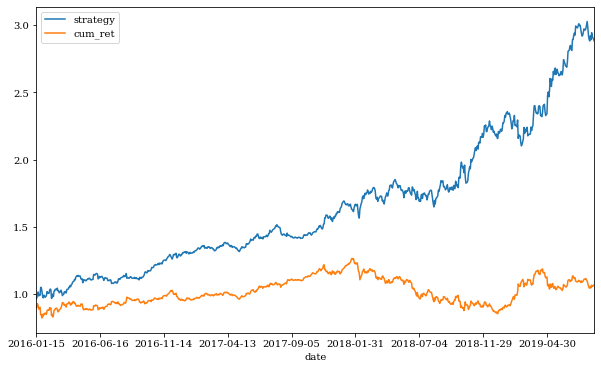

In [30]:
hs300[['strategy','cum_ret']].dropna().plot(figsize=(10, 6))

### 4. 改变算法：SVM

In [31]:
X_train = hs_7d

In [32]:
X_train

,close,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d
date,,,,,,,,
2016-01-14,3221.57,3155.88,3215.71,3192.45,3361.56,3294.38,3539.81,3478.78
2016-01-15,3118.73,3221.57,3155.88,3215.71,3192.45,3361.56,3294.38,3539.81
2016-01-18,3130.73,3118.73,3221.57,3155.88,3215.71,3192.45,3361.56,3294.38
2016-01-19,3223.12,3130.73,3118.73,3221.57,3155.88,3215.71,3192.45,3361.56
2016-01-20,3174.38,3223.12,3130.73,3118.73,3221.57,3155.88,3215.71,3192.45
...,...,...,...,...,...,...,...,...
2019-08-12,3699.10,3633.53,3669.29,3621.43,3636.33,3675.69,3747.44,3803.47
2019-08-13,3665.75,3699.10,3633.53,3669.29,3621.43,3636.33,3675.69,3747.44
2019-08-14,3682.40,3665.75,3699.10,3633.53,3669.29,3621.43,3636.33,3675.69


In [33]:
from sklearn.svm import SVC
clf_SVC = SVC(kernel = 'linear')

In [34]:
clf_SVC.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [35]:
clf_SVC.score(X_train, y_train)

0.541095890410959

In [36]:
hs300['prediction'] = np.NaN
hs300['prediction'].ix[7:] = clf_SVC.predict(X_train)

In [37]:
hs300['strategy'] = (hs300['prediction'].shift(1) * hs300['returns'] + 1).cumprod()
hs300['cum_ret'] = (hs300['returns']+1).cumprod()

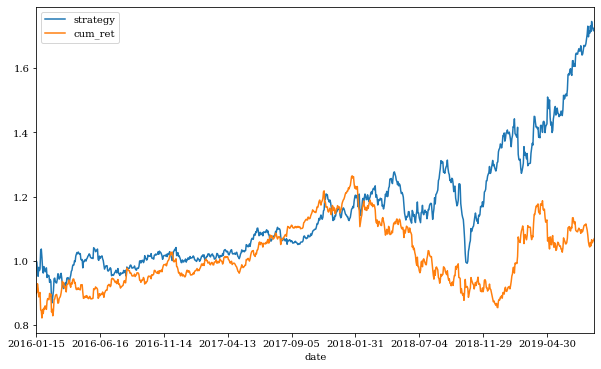

In [38]:
hs300[['strategy','cum_ret']].dropna().plot(figsize=(10, 6))

### 5. 逻辑回归算法在测试集的验证

In [39]:
hs300_test = ts.get_k_data('hs300', start = '2019-08-19', end = '2020-08-18')      #测试集数据

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [40]:
hs300_test.set_index('date', inplace = True)

In [41]:
hs300_test['returns'] = hs300_test['close'].pct_change()

In [42]:
hs300_test.dropna(inplace=True)

In [43]:
hs300_test.head()

,open,close,high,low,volume,code,returns
date,,,,,,,
2019-08-20,3786.03,3787.73,3799.90,3778.73,108602088.0,hs300,-0.000886
2019-08-21,3778.31,3781.76,3792.60,3775.45,82299880.0,hs300,-0.001576
2019-08-22,3793.86,3793.51,3797.33,3771.20,85807792.0,hs300,0.003107
2019-08-23,3796.88,3820.86,3829.36,3788.03,87954583.0,hs300,0.007210
2019-08-26,3756.36,3765.91,3778.87,3753.16,93859269.0,hs300,-0.014382


In [44]:
for i in range(1, 8, 1):
    hs300_test['close - ' + str(i) + 'd'] = hs300_test['close'].shift(i)

In [45]:
hs300_test.head()

,open,close,high,low,volume,code,returns,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d
date,,,,,,,,,,,,,,
2019-08-20,3786.03,3787.73,3799.90,3778.73,108602088.0,hs300,-0.000886,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-21,3778.31,3781.76,3792.60,3775.45,82299880.0,hs300,-0.001576,3787.73,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-22,3793.86,3793.51,3797.33,3771.20,85807792.0,hs300,0.003107,3781.76,3787.73,NaN,NaN,NaN,NaN,NaN
2019-08-23,3796.88,3820.86,3829.36,3788.03,87954583.0,hs300,0.007210,3793.51,3781.76,3787.73,NaN,NaN,NaN,NaN
2019-08-26,3756.36,3765.91,3778.87,3753.16,93859269.0,hs300,-0.014382,3820.86,3793.51,3781.76,3787.73,NaN,NaN,NaN


In [46]:
hs_7d_test = hs300_test[[x for x in hs300_test.columns if 'close' in x]].iloc[7:]

In [47]:
hs_7d_test.head()

,close,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d
date,,,,,,,,
2019-08-29,3790.19,3802.58,3816.95,3765.91,3820.86,3793.51,3781.76,3787.73
2019-08-30,3799.59,3790.19,3802.58,3816.95,3765.91,3820.86,3793.51,3781.76
2019-09-02,3848.32,3799.59,3790.19,3802.58,3816.95,3765.91,3820.86,3793.51
2019-09-03,3853.61,3848.32,3799.59,3790.19,3802.58,3816.95,3765.91,3820.86
2019-09-04,3886.00,3853.61,3848.32,3799.59,3790.19,3802.58,3816.95,3765.91


In [48]:
X_test = hs_7d_test 
X_test = sklearn.preprocessing.scale(X_test)
X_test

array([[-0.86497133, -0.81871021, -0.76311202, ..., -0.8301514 ,
        -0.86929194, -0.8433097 ],
       [-0.83246104, -0.86217511, -0.81406509, ..., -0.73039888,
        -0.82588816, -0.86564315],
       [-0.66392631, -0.82919932, -0.85799749, ..., -0.93081573,
        -0.72485896, -0.82168703],
       ...,
       [ 2.05929469,  2.14581338,  2.30339771, ...,  2.70495382,
         2.80746939,  2.85300715],
       [ 2.29765737,  2.10396219,  2.18234427, ...,  2.50497465,
         2.75446138,  2.85790779],
       [ 2.68017206,  2.34573788,  2.14004294, ...,  2.5667592 ,
         2.55192275,  2.80422521]])

In [49]:
hs300_test['prediction'] = np.NaN
hs300_test['prediction'].ix[7:] = lm.predict(X_test)    #给你测试集的features，返回的是预测的测试集的labels

In [50]:
hs300_test['prediction'].value_counts()

 1.0    136
-1.0     96
 0.0      2
Name: prediction, dtype: int64

In [51]:
hs300_test.head(10)

,open,close,high,low,volume,code,returns,close - 1d,close - 2d,close - 3d,close - 4d,close - 5d,close - 6d,close - 7d,prediction
date,,,,,,,,,,,,,,,
2019-08-20,3786.03,3787.73,3799.90,3778.73,108602088.0,hs300,-0.000886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-21,3778.31,3781.76,3792.60,3775.45,82299880.0,hs300,-0.001576,3787.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-22,3793.86,3793.51,3797.33,3771.20,85807792.0,hs300,0.003107,3781.76,3787.73,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-23,3796.88,3820.86,3829.36,3788.03,87954583.0,hs300,0.007210,3793.51,3781.76,3787.73,NaN,NaN,NaN,NaN,NaN
2019-08-26,3756.36,3765.91,3778.87,3753.16,93859269.0,hs300,-0.014382,3820.86,3793.51,3781.76,3787.73,NaN,NaN,NaN,NaN
2019-08-27,3791.46,3816.95,3848.24,3790.87,124731478.0,hs300,0.013553,3765.91,3820.86,3793.51,3781.76,3787.73,NaN,NaN,NaN
2019-08-28,3818.81,3802.58,3822.59,3790.14,88750812.0,hs300,-0.003765,3816.95,3765.91,3820.86,3793.51,3781.76,3787.73,NaN,NaN
2019-08-29,3805.49,3790.19,3808.60,3774.40,84083387.0,hs300,-0.003258,3802.58,3816.95,3765.91,3820.86,3793.51,3781.76,3787.73,1.0
2019-08-30,3816.68,3799.59,3828.97,3778.92,96695150.0,hs300,0.002480,3790.19,3802.58,3816.95,3765.91,3820.86,3793.51,3781.76,1.0


In [52]:
hs300_test['strategy'] = (hs300_test['prediction'].shift(1) * hs300_test['returns'] + 1).cumprod()
hs300_test['cum_ret'] = (hs300_test['returns']+1).cumprod()

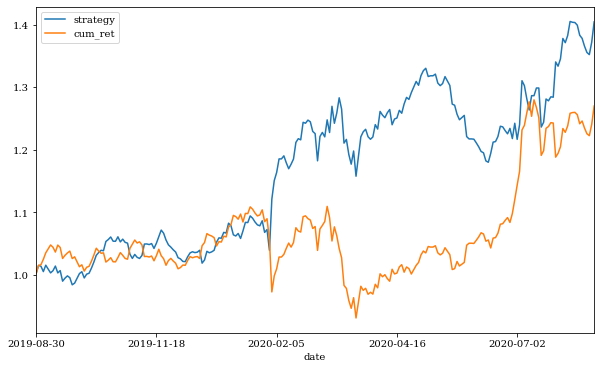

In [53]:
hs300_test[['strategy','cum_ret']].dropna().plot(figsize=(10, 6))

### 6.SVM算法在测试集的验证

In [54]:
X_test = hs_7d_test 

In [55]:
hs300_test['prediction'] = np.NaN
hs300_test['prediction'].ix[7:] = clf_SVC.predict(X_test)

In [56]:
hs300_test['strategy'] = (hs300_test['prediction'].shift(1) * hs300_test['returns'] + 1).cumprod()
hs300_test['cum_ret'] = (hs300_test['returns']+1).cumprod()

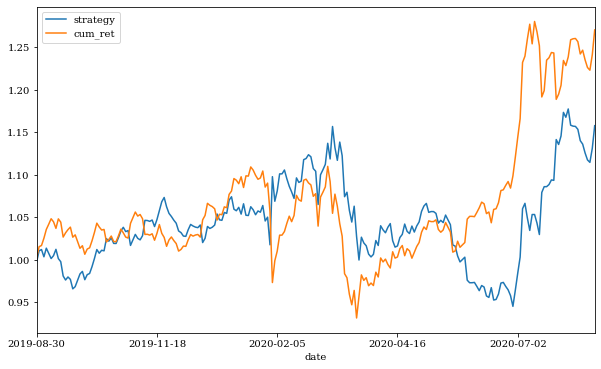

In [57]:
hs300_test[['strategy','cum_ret']].dropna().plot(figsize=(10, 6))